# CNN Image Model

In [50]:
# Import libraries
import pandas as pd
import os
import cv2
import tensorflow as tf
from PIL import Image
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import plotly.express as px
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

%matplotlib inline

# Build the Model

In [32]:
class CNNModel:
    '''Create and train a CNN model for classifying meme images'''
    def __init__(self, 
                 train_file, 
                 test_file,
                 final_test_file,
                 output_path,
                 picklepath,
):
        
        self.train_file = train_file
        self.test_file = test_file
        self.final_test_file = final_test_file
        self.output_path = output_path
        self.picklepath = picklepath
        
    def load_data(self):
        '''Load the data'''
        
        # Get the dataframes
        train_data = pd.read_json(self.train_file, lines = True)
        test_data = pd.read_json(self.test_file, lines = True)
        final_test_data = pd.read_json(self.final_test_file, lines = True)
        
        # Get the image and label arrays
        def get_pickle(picklepath):
            with open(picklepath, 'rb') as filehandler:
                data = pickle.load(filehandler)
            return data

        directory = self.picklepath

        train_file = directory + 'training_images.p'
        train_labels_file = directory + 'training_labels.p'
        test_file = directory + 'testing_images.p'
        test_labels_file = directory + 'testing_labels.p'
        final_test_file = directory + 'testing_final_images.p'
        final_test_labels_file = directory + 'testing_final_labels.p'

        train_images = get_pickle(train_file)
        train_labels = get_pickle(train_labels_file)
        test_images = get_pickle(test_file)
        test_labels = get_pickle(test_labels_file)
        final_test_images = get_pickle(final_test_file)
        final_test_labels = get_pickle(final_test_labels_file)
        
        # Make the labels categorical
        train_labels = tf.keras.utils.to_categorical(train_labels)
        test_labels = tf.keras.utils.to_categorical(test_labels)
        final_test_labels = tf.keras.utils.to_categorical(test_labels)
        
        return (train_images, 
                train_labels, 
                test_images,
                test_labels,
                final_test_images,
                final_test_labels,
                train_data,
                test_data,
                final_test_data)
    
    def visualize_data(self, x, y, p):
        '''Get a sample of the memes in the dataset
        
        Keyword arguments:
        x -- images
        y -- true labels
        p -- predictions
        
        '''
        
        # Code adapted from Coursera project Image Classification with CNN using Keras
        class_names = ['Not hate speech', 'Hate speech']
        
        
        indices = np.random.choice(range(x.shape[0]), 10, replace = False)

        x = x[indices]
        y = y[indices]
        p = p[indices]
            
        plt.figure(figsize = (20,10))
        for i in range(10):
            plt.subplot(2,5, 1 + i)
            plt.imshow(x[i])
            plt.xticks([])
            plt.yticks([])
            col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
            plt.xlabel(class_names[np.argmax(p[i])], color = col)
        plt.show()
        
    def train_model(self,
                   train_images,
                   train_labels,
                   test_images,
                   test_labels):
        
        '''Train the CNN model
        
        Keyword arguments:
        train_images -- preprocessed images used for training
        train_labels -- preprocessed labels of the training images
        test_images -- preprocessed images for the test data
        test_labels -- preprocessed labels for the test data
        
        Return:
        h -- the trained model
        '''
        
        # Code adapted from Coursera project Image Classification with CNN using Keras
        def create_model():
            def add_conv_block(model, num_filters):
                '''Create the model'''
                model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(num_filters, 3, activation='relu'))
                model.add(MaxPooling2D(pool_size=2))
                model.add(Dropout(0.1)) #.5
                return model

            model = tf.keras.models.Sequential()
            model.add(Input(shape=(200, 200, 3)))

            model = add_conv_block(model, 32)
            model = add_conv_block(model, 64)
            model = add_conv_block(model, 128)

            model.add(Flatten())
            model.add(Dense(2, activation='softmax'))

            model.compile(
                loss = 'categorical_crossentropy',
                optimizer='adam', metrics=[tf.keras.metrics.AUC()]
            )

            return model


        if not os.path.isdir(self.output_path):
            os.mkdir(self.output_path)
        
        model = create_model()
        model.summary()
        h = model.fit(
            train_images/255., train_labels, # divide by 255 to normalize data
            validation_data=(test_images/255., test_labels),
            epochs = 30, batch_size = 32,
            callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max',),
                tf.keras.callbacks.ModelCheckpoint(
                    self.output_path + '/model_{val_auc:.3f}.h5',
                    save_best_only=True, save_weights_only=False,
                    monitor='val_auc',
                    mode='max'
                )
            ]
        )
        
        return h

# Load the Data

In [33]:
model = CNNModel(train_file = 'hateful_memes/train.jsonl',
                test_file = 'hateful_memes/dev_seen.jsonl',
                final_test_file = 'hateful_memes/test_seen.jsonl',
                output_path = 'hateful_memes/cnn_models',
                picklepath = 'hateful_memes/pickles/')
(train_images, 
 train_labels, 
 test_images, 
 test_labels, 
 final_test_images, 
 final_test_labels, 
 train_data,
 test_data, 
 final_test_data) = model.load_data()

# Visualize Examples

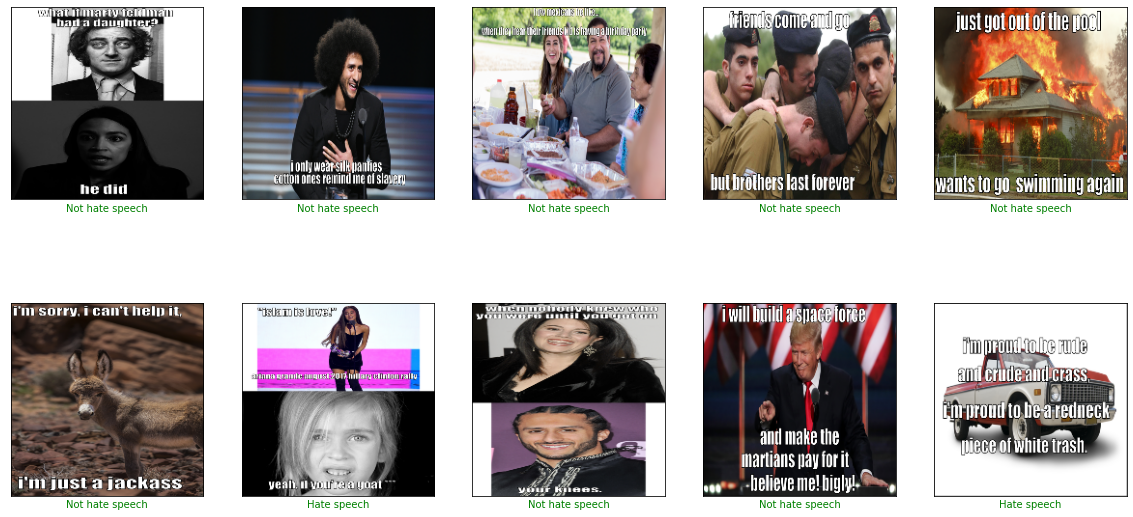

In [30]:
model.visualize_data(train_images, train_labels, train_labels)

# Train the Model

In [7]:
h = model.train_model(train_images, train_labels, test_images, test_labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 99, 64)        2

Epoch 1/30
266/266 [==============================] - 1458s 5s/step - loss: 1.8987 - auc: 0.6068 - val_loss: 0.7294 - val_auc: 0.4952
Epoch 2/30
266/266 [==============================] - 624s 2s/step - loss: 0.6504 - auc: 0.6776 - val_loss: 0.6969 - val_auc: 0.4844
Epoch 3/30
266/266 [==============================] - 619s 2s/step - loss: 0.6446 - auc: 0.6894 - val_loss: 0.6942 - val_auc: 0.5181
Epoch 4/30
266/266 [==============================] - 615s 2s/step - loss: 0.6329 - auc: 0.6963 - val_loss: 0.7507 - val_auc: 0.5219
Epoch 5/30
266/266 [==============================] - 633s 2s/step - loss: 0.6239 - auc: 0.7108 - val_loss: 0.7260 - val_auc: 0.5271
Epoch 6/30
266/266 [==============================] - 638s 2s/step - loss: 0.6172 - auc: 0.7222 - val_loss: 0.9331 - val_auc: 0.5267
Epoch 7/30
266/266 [==============================] - 644s 2s/step - loss: 0.6158 - auc: 0.7218 - val_loss: 0.7965 - val_auc: 0.5229
Epoch 8/30
266/266 [==============================] - 631s 2s/step -

## Use the best model to get AUC on the hold out test set

In [60]:
class BestModel:
    '''Load the best model and see how it performs on the hold out
    test set
    '''
    def __init__(self,
               model_file,
               final_test_images,
               final_test_data,
               train_images,
               train_data):
        self.model_file = model_file
        self.final_test_images = final_test_images
        self.final_test_data = final_test_data
        self.train_images = train_images
        self.train_data = train_data
        self.loaded_model = tf.keras.models.load_model(self.model_file)
        self.final_test_predictions = self._make_predictions(self.final_test_images)
        self.train_predictions = self._make_predictions(self.train_images)
        self.final_test_auc = self._auc()
        self.train_auc = self._auc(final=False)
    
    def _make_predictions(self, images):
        return self.loaded_model.predict(images)[:,1]
    
    def _auc(self, final = True):
        if final:
            preds = self.final_test_predictions
            data = self.final_test_data
        else:
            preds = self.train_predictions
            data = self.train_data
        preds = preds
        labels = np.array(data.label)
        auc = roc_auc_score(labels, preds)
        return auc
    
    def _roc_curve(self, final = True):
        if final:
            labels = np.array(self.final_test_data.label)
            preds = self.final_test_predictions
        else:
            labels = np.array(self.train_data.label)
            preds = self.train_predictions
            
        fpr, tpr, _ = roc_curve(labels, preds, pos_label = 1)
        return fpr, tpr
    
    def create_roc_curve(self):
        test_fpr, test_tpr = self._roc_curve()
        train_fpr, train_tpr = self._roc_curve(final=False)
        
        # Create a dataframe of fpr and tpr to create visual
        testRocDf = pd.DataFrame({'fpr': test_fpr, 'tpr': test_tpr, 'data':['test']*len(test_tpr)})
        trainRocDf = pd.DataFrame({'fpr': train_fpr, 'tpr': train_tpr, 'data': ['train'] * len(train_tpr)})
        rocDf = pd.concat([testRocDf, trainRocDf])
        
        # Create the ROC curve
        fig = px.line(rocDf, 
                      x = 'fpr', 
                      y = 'tpr',
                      color = 'data',
                      color_discrete_sequence=['orange', 'blue'],
                     title = 'Image CNN ROC Curve (Test AUC: {})'.format(round(self.final_test_auc,2)))
        fig.update_layout({
            'plot_bgcolor': 'rgba(0,0,0,0)',
            'paper_bgcolor':'rgba(0,0,0,0)'
        })
        fig.show()

In [61]:
# Load the best model
loaded_model = BestModel(
    model_file = 'hateful_memes/cnn_models/model_0.533.h5',
    final_test_images = final_test_images,
    final_test_data = final_test_data,
    train_images = train_images,
    train_data = train_data
)

In [62]:
# Create the roc curve
loaded_model.create_roc_curve()